In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
points=100
T = np.linspace(0.2,2.2,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th

e = -J*( th + ch*thN )/( 1 + thN )


## INTERNAL ENERGY
$U(N,T)/N = \langle H \rangle_{h=0}$

In [17]:
file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/InternalEnergy_metro.csv"
df = pd.read_csv(file,sep ="\t")

file = "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/InternalEnergy_Gibbs.csv"
dfG = pd.read_csv(file,sep ="\t")

df
dfG

,TEMPERATURE,U_AVE,ERROR
0,2.00,-0.462181,0.000104
1,1.82,-0.500145,0.000123
2,1.64,-0.544065,0.000122
3,1.46,-0.594915,0.000135
4,1.28,-0.653396,0.000174
5,1.10,-0.721048,0.000131
6,0.92,-0.795838,0.000208
7,0.74,-0.874526,0.000256
8,0.56,-0.951020,0.000455
9,0.38,-0.997506,0.000201


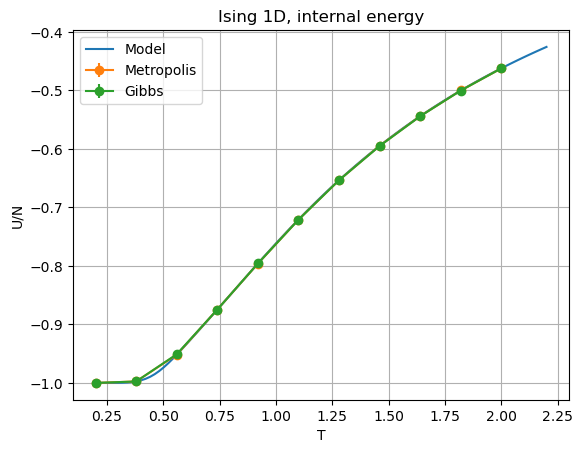

In [39]:
plt.plot(T, e, label ='Model')
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')

plt.errorbar(df['TEMPERATURE'],df['U_AVE'], yerr = df["ERROR"],marker = 'o', label= 'Metropolis')
plt.errorbar(dfG['TEMPERATURE'],dfG['U_AVE'], yerr = dfG["ERROR"],marker = 'o', label = 'Gibbs')
plt.legend()
plt.grid()

plt.show()


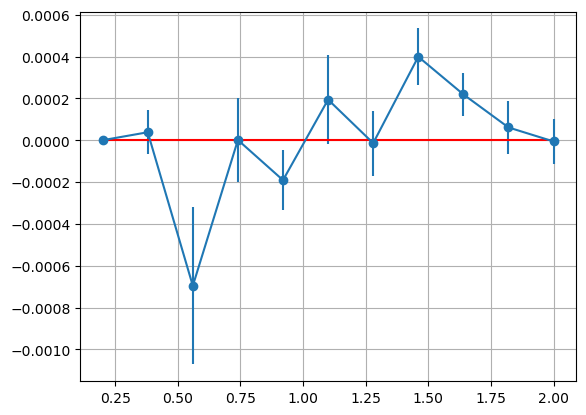

In [43]:
plt.errorbar(df['TEMPERATURE'],df['U_AVE']-dfG['U_AVE'], yerr = df["ERROR"],marker = 'o')
plt.grid()
plt.hlines(0,0.2,2, color='red')
plt.show()

## HEAT CAPACITY
$C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 

In [21]:
file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/CV_metro.csv"
df1 = pd.read_csv(file,sep ="\t")

file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/CV_Gibbs.csv"
dfG1 = pd.read_csv(file,sep ="\t")

df1
dfG1

,TEMPERATURE,CV_AVE,ERROR
0,2.00,0.192675,0.000022
1,1.82,0.221857,0.000037
2,1.64,0.256509,0.000049
3,1.46,0.297034,0.000077
4,1.28,0.342784,0.000135
5,1.10,0.388810,0.000153
6,0.92,0.424513,0.000391
7,0.74,0.420784,0.000827
8,0.56,0.296587,0.002732
9,0.38,0.033153,0.002667


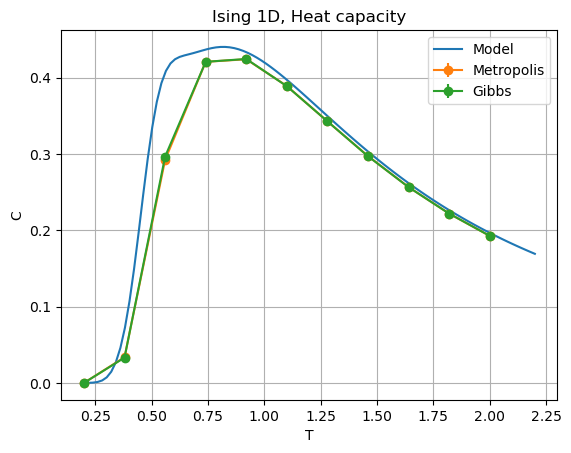

In [37]:
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T, heat, label = 'Model')
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')

plt.errorbar(df1['TEMPERATURE'],df1['CV_AVE'], yerr = df1["ERROR"], marker='o', label = 'Metropolis')
plt.errorbar(dfG1['TEMPERATURE'],dfG1['CV_AVE'], yerr = dfG1["ERROR"], marker='o', label = 'Gibbs')
plt.legend()
plt.grid()
plt.show()

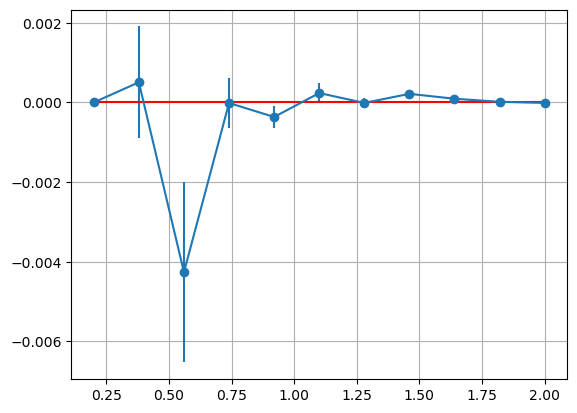

In [46]:
plt.errorbar(df1['TEMPERATURE'],df1['CV_AVE']-dfG1['CV_AVE'], yerr = df1["ERROR"],marker = 'o')
plt.grid()
plt.hlines(0,0.2,2, color='red')
plt.show()

## SUSCEPTIBILITY
$\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$

In [23]:
file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/Chi_metro.csv"
df2 = pd.read_csv(file,sep ="\t")

file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/Chi_Gibbs.csv"
dfG2 = pd.read_csv(file,sep ="\t")

df2
dfG2

,TEMPERATURE:,X_AVE:,ERROR:
0,2.00,1.35869,3.028440e-03
1,1.82,1.64518,4.040940e-03
2,1.64,2.05946,4.302260e-03
3,1.46,2.70162,6.231530e-03
4,1.28,3.69814,1.104920e-02
5,1.10,5.60824,2.011210e-02
6,0.92,9.59617,4.514400e-02
7,0.74,20.02770,1.554280e-01
8,0.56,55.51180,3.868230e-01
9,0.38,128.77700,2.718030e-01


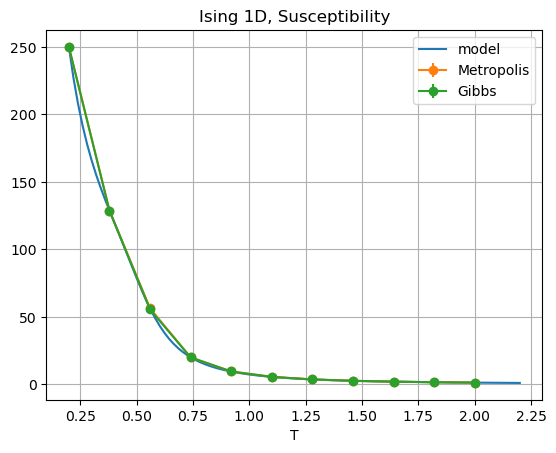

In [36]:
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T, X, label = 'model')
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')

plt.errorbar(df2['TEMPERATURE:'],df2['X_AVE:'], yerr = df2["ERROR:"], marker='o', label = 'Metropolis')
plt.errorbar(dfG2['TEMPERATURE:'],dfG2['X_AVE:'], yerr = dfG2["ERROR:"], marker='o', label = 'Gibbs')
plt.legend()
plt.grid()

plt.show()

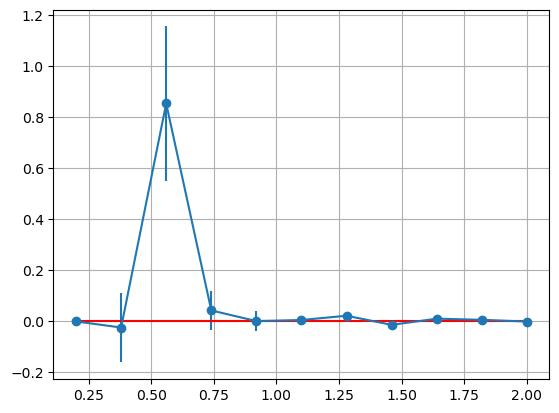

In [48]:
plt.errorbar(df2['TEMPERATURE:'],df2['X_AVE:']-dfG2['X_AVE:'], yerr = df2["ERROR:"],marker = 'o')
plt.grid()
plt.hlines(0,0.2,2, color='red')
plt.show()

#### MAGNETIZATION
$M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

In [28]:
file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/Magnetization_metro.csv"
df3 = pd.read_csv(file,sep ="\t")

file= "/home/elisa/Scrivania/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/Magnetization_Gibbs.csv"
dfG3 = pd.read_csv(file,sep ="\t")

df3
dfG3

,TEMPERATURE,M_AVE,ERROR
0,2.00,0.026990,0.000491
1,1.82,0.033092,0.000641
2,1.64,0.040283,0.000608
3,1.46,0.053703,0.000813
4,1.28,0.076592,0.000999
5,1.10,0.114319,0.001238
6,0.92,0.191412,0.002404
7,0.74,0.373003,0.004188
8,0.56,0.773046,0.006919
9,0.38,0.986134,0.009656


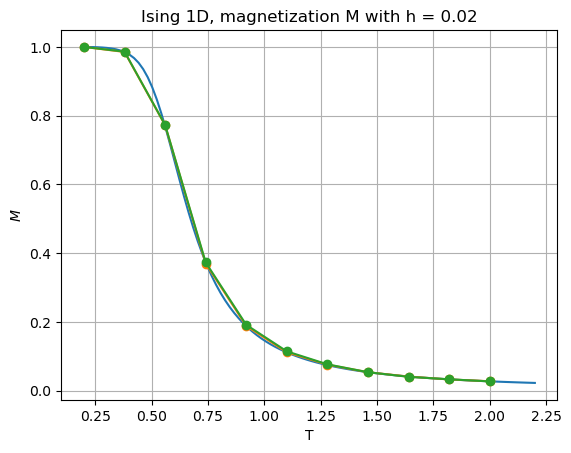

In [35]:
h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)


plt.plot(T, M, label = 'Model')
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')


plt.errorbar(df3['TEMPERATURE'],df3['M_AVE'], yerr = df3["ERROR"], marker='o', label = 'Metropolis')
plt.errorbar(dfG3['TEMPERATURE'],dfG3['M_AVE'], yerr = dfG3["ERROR"], marker='o', label = 'Gibbs')
plt.grid()
plt.show()

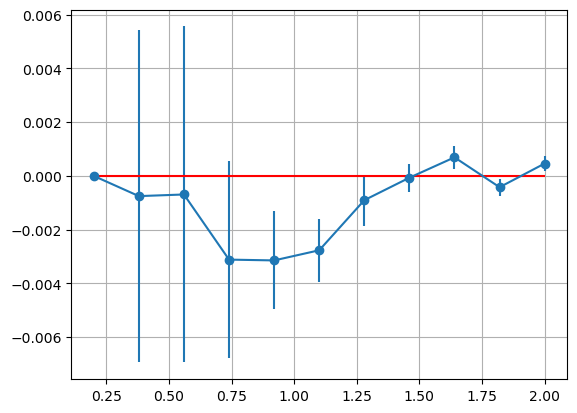

In [49]:
plt.errorbar(df3['TEMPERATURE'],df3['M_AVE']-dfG3['M_AVE'], yerr = df3["ERROR"],marker = 'o')
plt.grid()
plt.hlines(0,0.2,2, color='red')
plt.show()

## DA FARE:

Controllare CV 

Controllare se gibbs è giusto 

Fare propagazione errori per il plot delle differenze 